# Part 5 - Competition

We're at the end of the course and it's time for you to play with some data!

Until your presentations (and perhaps a little longer) you'll have time to implement your own models to predict from spiking neuronal activity, which one of two different videos was shown to a monkey (referred to as just conditions A and B) while multiple (in our case 7) neurons were recorded.

In your presentations, you should present your progress with the model (what you tried and where you struggeled), as well as a progress report of the block-course in general.




Now its time to get our hands dirty.

The next two cells load and plot the data that you'll use in our small course-internal competition.
First of all, we import some handy functions form the previous notebooks.

In [83]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
import statsmodels.api as sm
from scipy.ndimage.filters import gaussian_filter1d

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles
    
def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))

The cell below loads and displays the data you can use in the competition.

The data is made accessible in multipe ways (pick which ever is most convenient for you):


 * The two arrays `cond_A` and `cond_B`, both of which have the shape [$\text{cells}\times N \times T$], contain the spike-trains belonging to the recorded neurons in condition A or B, respectively:
     * `cond_A` contains for each of 7 cells (recorded under condition A) `N` trials of `T` timesteps each 
     * `cond_B` contains for each of 7 cells (recorded under condition B) `N` trials of `T` timesteps each 
 * The array `cond_X` contains testing data of the shape [$\text{cells}\times N\_test \times T$]:
     * `cond_X` contains for each of 7 cells (recorded under either condition A or B) `N_test` trials of `T` timesteps each
     * for each trial in `cond_X`, the condition the neurons were in is unknown, but it is the same for all 7 neurons across all T timesteps
 * The same data as stored in `cond_A` and `cond_B` can also be accessed via the matrix `spikes`, which contains both training data of condition A and B and has a shape of [$\text{cells}\times \text{conditions} \times N \times T$]:
    * spikes[:,0,:,:] is equal to cond_A
    * spikes[:,1,:,:] is equal to cond_B
   


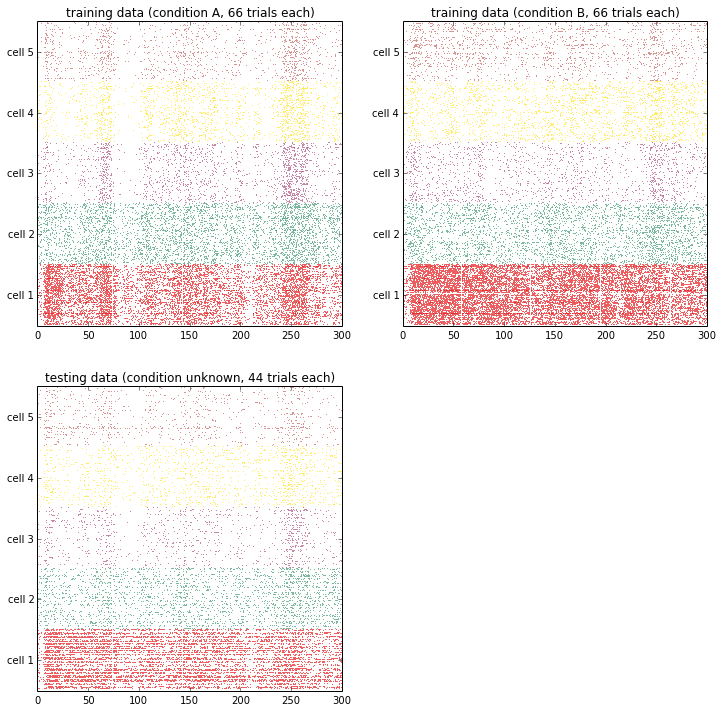

In [82]:
#resolution_reduction          = 10           # You can change this
#cells_used                    = slice(None)  # You can change this   ( a[slice(None)] is equivalent to a[:])
#interval_used                 = slice(None)  # You can change this   ( e.g. a[slice(50,600)] is equivalent to a[50:600]

resolution_reduction          = 10              #
cells_used                    = slice(2,None)   # Drop the first two neurons, because they seem to do something else
interval_used                 = slice(100,400)  # apparently, the stimulus is only present between t=100 and t=400

with np.load('data.npz') as archive:
    cond_A = reduce_resolution(archive['spikes_competitionA'],resolution_reduction)[cells_used,0,:,interval_used]
    cond_B = reduce_resolution(archive['spikes_competitionB'],resolution_reduction)[cells_used,0,:,interval_used]
    cond_X = reduce_resolution(archive['spikes_competitionTest'],resolution_reduction)[cells_used,0,:,interval_used]
cells, N, T = cond_A.shape
N_test = cond_X.shape[1]

spikes = np.zeros((cells,2,N,T))
spikes[:,0,:,:] = cond_A
spikes[:,1,:,:] = cond_B


figure(figsize = (12,12))
ax = [subplot(2,2,1), subplot(2,2,2), subplot(2,2,3)]
for cond in range(2):
    for cell in range(cells):
        spike_y, spike_t = np.nonzero(cond_A[cell] if cond == 0 else cond_B[cell])
        ax[cond].plot(spike_t,N*(cell+1)-spike_y, ",", color=cm.Set1(float(cell)/cells), alpha=0.7,ms=3)
    ax[cond].set_ylim([0,cells*N])
    ax[cond].set_yticks(np.linspace(N/2, N/2 + N*cells, cells, endpoint=False));
    ax[cond].set_yticklabels(["cell %d" % (v+1) for v in range(cells)]);
    ax[cond].set_title("training data (condition A, %d trials each)" % N if cond == 0 else "training data (condition B, %d trials each)" % N)

figure(figsize = (6,8))
for cell in range(cells):
    spike_y, spike_t = np.nonzero(cond_X[cell])
    ax[2].plot(spike_t,N_test*(cell+1)-spike_y, ",", color=cm.Set1(float(cell)/cells), alpha=0.7,ms=3)
ax[2].set_ylim([0,cells*N_test])
ax[2].set_yticks(np.linspace(N_test/2, N_test/2 + N_test*cells, cells, endpoint=False));
ax[2].set_yticklabels(["cell %d" % (v+1) for v in range(cells)]);
ax[2].set_title("testing data (condition unknown, %d trials each)" % N_test)

### Your task for the competition:

The array `cond_X` gives you 44 testing trials, in the form of a spike-train each from 7 simultaneously recorded neurons. You see an illustration of this data in the bottom plot above.

Your task is to decide for each of these 44 testing trials, whether they were recorded under condition A or B, i.e. in the end you should produce a vector of length 44 that contains a $0$ where your model predicts that a testing trial belongs to condition A and a 1 where it predicts that the testing trial belongs to condition $B$.
To achieve this, we want to use a Generalized Linear model similar to the one discussed in the block-course so far.


One way to tackle this problem was already mentioned in the lecture:


You could create a model for each neuron under each condition (i.e. you end up with $7\cdot2 = 14$ models)
and fit these models on the corresponding training data.
You could then plug the 7 spike-trains that make up one testing trial into your $7$ models trained on condition A and then into the $7$ models trained on condition B. This gives you $14$ values per testing trial that you need to somehow need to turn into a prediction of either 0 or 1.

An easy approach would be, to assume each neuron makes an independent prediction.
Under this assumption, the joint log-likelihood of a test trial under condition A can be derived as just the sum of the log-likelihoods of the test trial under condition A **given by each neuron**. The same could be done for condition B, giving you just two values for each testing trial: the likelihood of condition A and that of condition B. A reasonable prediction for that test trial then is to just pick the condition with higher likelihood.

Alternatively, you could make a "democratic" decision, where you first calculate for each cell individually which of its two models (trained on condition A or B) has the higher likelihood for the testing trial, and you choose the condition that wins for the majority of cells as your prediction for that testing trial (if you use an odd number of cells, there will always be a winner).


A good place to start might be to go through the previous notebooks and implement a simple model with rate component that you can fit on one cell for one condition and then build on that.

There are many things left for you to experiment with, amongst them the following:

 * You can decide which cells to include/exclude from your model (see cell above).
 * You can decide to cut out a shorter time-interval of the spike-trains (e.g. the first few steps seem hardly informative; see cell above).
 * You can (un)reduce the resolution by a different factor.
 * You can chose whether or not to use auto-/cross-history components.
 * You can chose whether to use linearly spaced knots or the technique we used.
 * You can choose the numbers of basis functions for rate and/or history components.
 * If you feel like it, you could use a model-selection method like AIC or cross-validation to find good values for e.g the number of knots for B-splines
 * You can change parameters like sigma, the spline orders or the history_length
 * ...
 
A few hints that might help you get started:

 * it could be very helpful to implement 2 functions, one that calculates a design-matrix for history components (for one trial) and one that calculates a design-matrix for rate components (also for one trial)
 * the design matrix for the rate component is identical across different trials, but if you use adaptive knot spacing it depends on the neuron and condition
 * the design matrix for the history components depends on spiking data of individual trials ad thus needs to be re-calculated for every condition and every trial, but if you treat auto-history and cross-history identically, this design-matrix is identical for all cells
 * You'll have to combine 7 cells into a single prediction. If you don't know how to start, you can make this problem easier by just picking out a single cell and trying to do prediction based on just this one cell.
 
#### Submitting your solutions:
At the end of the competition (deadline will be announced), upload a notebook that contains your model as well as a comma separated value file (.csv) that contains your 44 predictions as 0s and 1s to the courses Stud.IP folder called "Submissions". You can create such a file directly from within the ipython notebook using code like:

    group_name = "rzlogin1_rzlogin2_rzlogin3"
    numpy.savetxt(group_name+'_prediction.csv', prediction, fmt='%d', delimiter=',')
    
Please document your notebooks, and don't forget to discuss your current progress during your presentation of friday!

In [33]:
rate_num_knots       = 20
history_num_knots    = 5
rate_spline_order    = 3
history_spline_order = 3
sigma                = 50/resolution_reduction
history_length       = 100/resolution_reduction

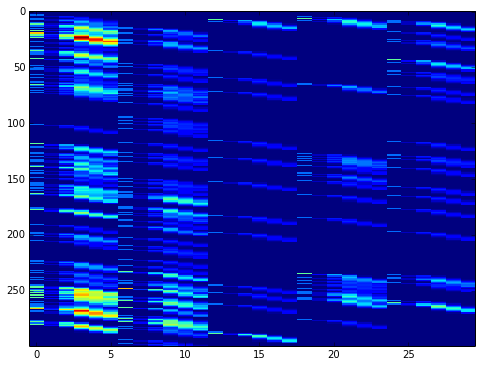

In [34]:
def calculate_history_dm(cell_spiketrains, num_knots=5, history_length=20, order=3):
    """ Calculates a history design matrix for a single trial and multiple neurons """
    if cell_spiketrains.ndim == 1:
        cell_spiketrains = cell_spiketrains.reshape((1,-1))
    knots   = splines.augknt(np.logspace(0,np.log10(history_length),num_knots),order)[:-1]                       
    bases   = splines.spcol(np.linspace(1+1e-10,history_length,history_length),knots,order)
    kernels = np.vstack([np.zeros_like(bases), bases])
    dm_cols = []
    for i,spiketrain in enumerate(cell_spiketrains):
        for j,kernel in enumerate(kernels.T):
            dm_cols.append(np.convolve(spiketrain, kernel,"same"))
    return np.vstack(dm_cols).T

figure(figsize=(8,6))
imshow(calculate_history_dm(spikes[:,0,0,:], num_knots=history_num_knots, history_length=history_length, order=history_spline_order),aspect='auto',interpolation='nearest')

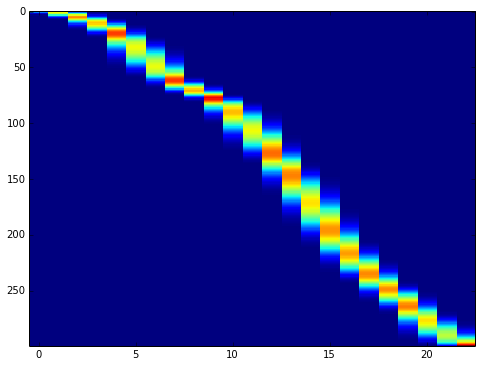

In [35]:
def calculate_rate_dm(trial_spiketrains, num_knots=50, order=3, sigma=10):
    cum_d   = calc_cum_abs_deriv(trial_spiketrains.sum(axis=0), sigma=sigma, order=1)
    knots   = splines.augknt(find_percentiles(cum_d, num_knots), order)
    return np.array(splines.spcol(range(int(knots[-1]+0.5)),knots,order))

figure(figsize=(8,6))
imshow(calculate_rate_dm(spikes[0,0,:,:], num_knots=rate_num_knots, order=rate_spline_order, sigma=sigma),aspect='auto',interpolation='nearest')

In [36]:
# each cell has a different rate design matrix for each condition, but they are identical across trials
# each cell has the same history design matrix, but there is one for each condition and trial

rate_dms = []
for cell in range(cells):
    rate_dms.append([])
    for condition in range(2):
        # calculate rate design matrix
        rate_dm = calculate_rate_dm(spikes[cell,condition,:,:], num_knots=num_rate_knots, order=rate_spline_order, sigma=sigma)
        rate_dms[cell].append(rate_dm)

history_dms = []
for condition in range(2):
    history_dms.append([])
    for trial in range(N):
        # calculate history design matrix
        history_dm = calculate_history_dm(spikes[:,condition,trial,:], num_knots=history_num_knots, history_length=history_length, order=history_spline_order)
        history_dms[condition].append(history_dm)

In [37]:
models = []
for cell in range(cells):
    models.append([])
    for condition in range(2):
        print "Fitting model for cell %d on condition %d" % (cell, condition)
        dm = np.array(np.bmat([[history_dms[condition][trial], rate_dms[cell][condition]] for trial in range(N)]))
        
        spikes_nospikes = np.array([spikes[cell,condition,:,:].ravel(), resolution_reduction-spikes[cell,condition,:,:].ravel()]).T
        model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
        fitted_model = model.fit()
        fitted_model.remove_data()
        
        models[cell].append(fitted_model);

Fitting model for cell 0 on condition 0
Fitting model for cell 0 on condition 1
Fitting model for cell 1 on condition 0
Fitting model for cell 1 on condition 1
Fitting model for cell 2 on condition 0
Fitting model for cell 2 on condition 1
Fitting model for cell 3 on condition 0
Fitting model for cell 3 on condition 1
Fitting model for cell 4 on condition 0
Fitting model for cell 4 on condition 1


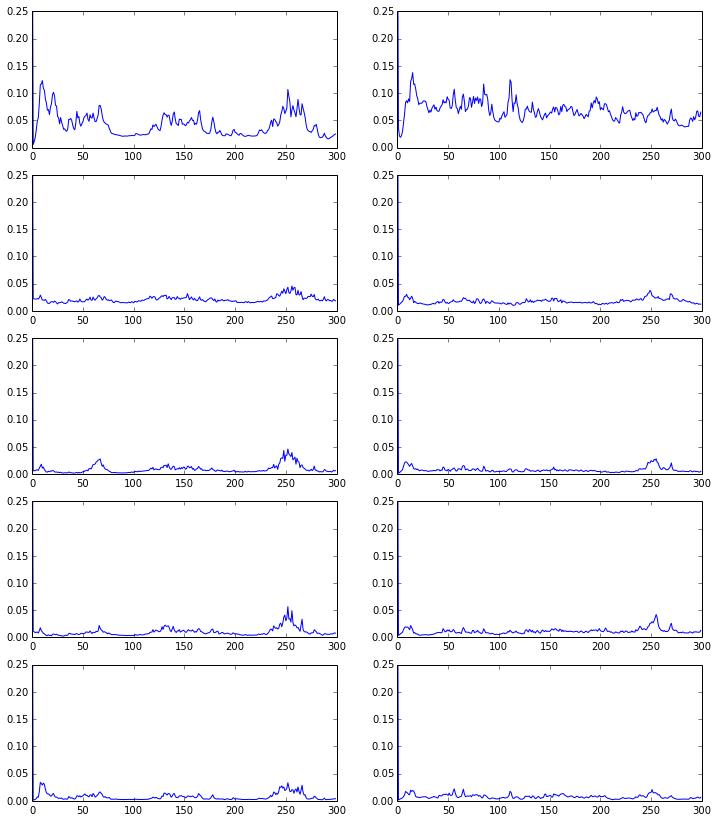

In [38]:
figure(figsize=(12,20))
for cell in range(cells):
    for condition in range(2):
        subplot(7,2,1+ condition + 2*cell)
        plot(models[cell][condition].predict(np.hstack([history_dms[condition][0], rate_dms[cell][condition]])))
        ylim([0,0.25])
    

In [39]:
from scipy.stats import binom
def ll(ps,xs,n=1):
    return binom.logpmf(xs, n, ps).sum()

In [40]:
likelihood = np.zeros((N_test, cells, 2))

for trial in range(N_test):
    test_history_dm = calculate_history_dm(cond_X[:,trial,:], num_knots=history_num_knots, history_length=history_length, order=history_spline_order)
    for cell in range(cells):
        spiketrain = cond_X[cell,trial,:]
        for condition in range(2):
            prediction = models[cell][condition].predict(np.hstack([test_history_dm, rate_dms[cell][condition]]))
            likelihood[trial,cell,condition] = ll(prediction, spiketrain,n=resolution_reduction)

In [75]:
likelihood_ratio = likelihood[:,:,1] - likelihood[:,:,0]
cllr = likelihood_ratio.sum(axis=1)
pred = (lld>0)
target = np.array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0],dtype=bool)
performance = min((pred == corr).mean(), (pred != corr).mean() )

print "The model classified a fraction of %g trials correctly! (chance level is 0.5)" % performance

The model classified a fraction of 0.0227273 trials correctly! (chance level is 0.5)


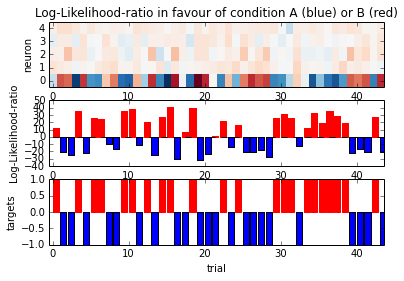

In [76]:
ax1 = subplot(3,1,1)
ax1.imshow(likelihood_ratio.T, cmap=cm.RdBu, aspect="auto", interpolation="nearest")
title("Log-Likelihood-ratio in favour of condition A (blue) or B (red)")
ylabel("neuron")
ylim([-0.5,4.5])

subplot(3,1,2, sharex=ax1)

barlist = bar(np.arange(N_test),lld ,color="b")
for i in np.where(pred)[0]:
    barlist[i].set_color('r')
plot([0,N_test],[0,0],'k--')
ylabel("Log-Likelihood-ratio")

ax3=subplot(3,1,3, sharex=ax1)

barlist = bar(np.arange(N_test),target*2-1 ,color="b")
for i in np.where(target)[0]:
    barlist[i].set_color('r')
xlim([-0.5,N_test-0.5])
ylim([-1.0,1.0])
xlabel("trial")
ylabel("targets")

That's it for part 5! And the whole course
============================================

(Now you can start on your presentations)